# Titanic Survival Prediction

## Data Dictionary
| Variable| Definition| Key                                             |
|---|---|-------------------------------------------------|
| survival| Survival| 0 = No, 1 = Yes                                 |
| pclass| Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd                       |
| sex| Sex                                                                |
| Age| Age in years                                                       |
| sibsp| # of siblings / spouses aboard the Titanic                         |
| parch| # of parents / children aboard the Titanic                         |
| ticket| Ticket number                                                      |
| fare| Passenger fare                                                     |
| cabin| Cabin number                                                       |
| embarked| Port of Embarkation| C = Cherbourg, Q = Queenstown, S = Southampton |

## Variable Notes
**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sns.set_theme(style="darkgrid", palette="dark")

## Exploratory Data Analysis (EDA)

### Reading Dataset
Data is from <https://www.kaggle.com/competitions/titanic/data>.

In [3]:
train_df = pd.read_csv("train.csv")

In [4]:
test_df = pd.read_csv("test.csv")

### Viewing Data

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


### Data Dimensions

In [9]:
train_df.shape

(891, 12)

In [10]:
test_df.shape

(418, 11)

### Merging Data

In [11]:
objs = [train_df, test_df]
combined_df = pd.concat(objs, keys=["Train", "Test"])

combined_df.head()

PassengerId  Survived  Pclass  \
Train 0            1       0.0       3   
      1            2       1.0       1   
      2            3       1.0       3   
      3            4       1.0       1   
      4            5       0.0       3   

                                                      Name     Sex   Age  \
Train 0                            Braund, Mr. Owen Harris    male  22.0   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
      2                             Heikkinen, Miss. Laina  female  26.0   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
      4                           Allen, Mr. William Henry    male  35.0   

         SibSp  Parch            Ticket     Fare Cabin Embarked  
Train 0      1      0         A/5 21171   7.2500   NaN        S  
      1      1      0          PC 17599  71.2833   C85        C  
      2      0      0  STON/O2. 3101282   7.9250   NaN        S  
      3      1      0            113803  53.1000  C123        S  
      4      0      0            373450   8.0500   NaN        S

In [12]:
combined_df.tail()

PassengerId  Survived  Pclass                          Name     Sex  \
Test 413         1305       NaN       3            Spector, Mr. Woolf    male   
     414         1306       NaN       1  Oliva y Ocana, Dona. Fermina  female   
     415         1307       NaN       3  Saether, Mr. Simon Sivertsen    male   
     416         1308       NaN       3           Ware, Mr. Frederick    male   
     417         1309       NaN       3      Peter, Master. Michael J    male   

           Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
Test 413   NaN      0      0           A.5. 3236    8.0500   NaN        S  
     414  39.0      0      0            PC 17758  108.9000  C105        C  
     415  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
     416   NaN      0      0              359309    8.0500   NaN        S  
     417   NaN      1      1                2668   22.3583   NaN        C

In [13]:
combined_df.shape

(1309, 12)

### Column Names

In [14]:
combined_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Metadata

In [15]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('Train', 0) to ('Test', 417)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 166.0+ KB


### Descriptive Statistics

In [16]:
object_columns = ["PassengerId", "Survived", "Pclass"]
dtype = {column: "object" for column in object_columns}
df = combined_df.astype(dtype)

df.describe()

,Age,SibSp,Parch,Fare
count,1046.000000,1309.000000,1309.000000,1308.000000
mean,29.881138,0.498854,0.385027,33.295479
std,14.413493,1.041658,0.865560,51.758668
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


In [17]:
df.describe(include="object")

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,1309,891.0,1309,1309,1309,1309,295,1307
unique,1309,2.0,3,1307,2,929,186,3
top,1,0.0,3,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,1,549.0,709,2,843,11,6,914


### Checking for Missing Values

In [18]:
null_sums = combined_df.isnull().sum()

null_sums[null_sums > 0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

### Checking for Duplicated Rows

In [19]:
combined_df.duplicated().sum()

0

### Distribution of Survived

[Text(0, 0, '61.6% (549)'), Text(0, 0, '38.4% (342)')]

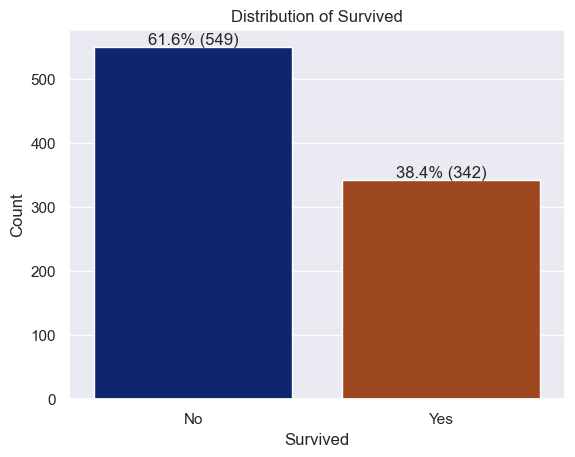

In [20]:
plot = sns.countplot(data=train_df, x="Survived")
title = "Distribution of Survived"
plot.set(
    ylabel="Count", xticklabels=["No", "Yes"], title=title
)
labels=[
    f"{v.get_height() / len(train_df):.1%}"
    f" ({v.get_height():.0f})"
    for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '63.0%'), Text(0, 0, '47.3%'), Text(0, 0, '24.2%')]

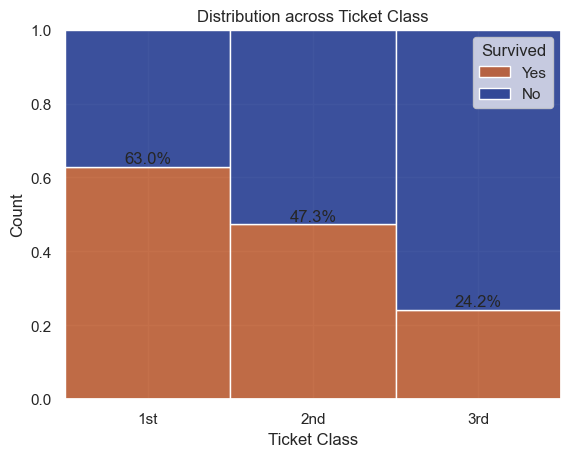

In [21]:
df = train_df.loc[:, ["Survived"]]
mappings = {1: "1st", 2: "2nd", 3: "3rd"}
df["Ticket Class"] = train_df.Pclass.map(mappings)
df.sort_values("Ticket Class", inplace=True)

x, hue = "Ticket Class", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")

plot.set_title("Distribution across Ticket Class")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '18.9%'), Text(0, 0, '74.2%')]

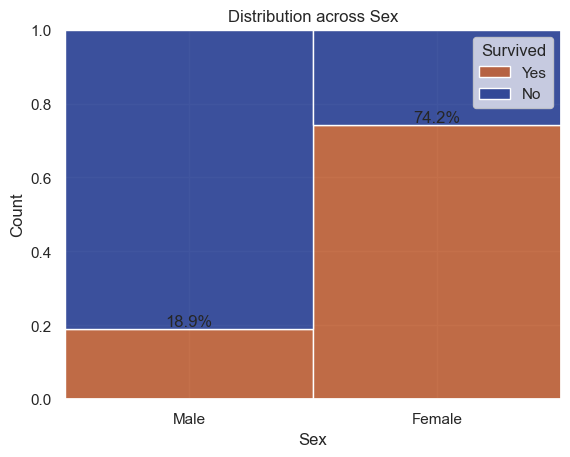

In [22]:
df = train_df.loc[:, ["Survived"]]
df["Sex"] = train_df.Sex.str.title()

x, hue = "Sex", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title("Distribution across Sex")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '34.5%'),
 Text(0, 0, '53.6%'),
 Text(0, 0, '46.4%'),
 Text(0, 0, '25.0%'),
 Text(0, 0, '16.7%'),
 Text(0, 0, '0.0%'),
 Text(0, 0, '0.0%')]

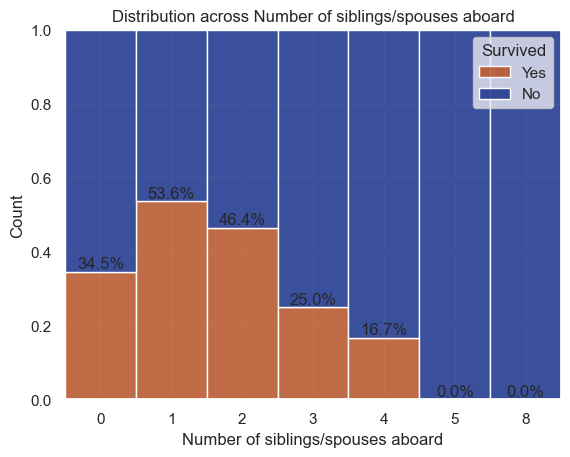

In [23]:
x, hue = "Number of siblings/spouses aboard", "Survived"
df = train_df.loc[:, ["Survived"]]
df[x] = train_df.SibSp.apply(str)
df.sort_values(x, inplace=True)

plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title(f"Distribution across {x}")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '34.4%'),
 Text(0, 0, '55.1%'),
 Text(0, 0, '50.0%'),
 Text(0, 0, '60.0%'),
 Text(0, 0, '0.0%'),
 Text(0, 0, '20.0%'),
 Text(0, 0, '0.0%')]

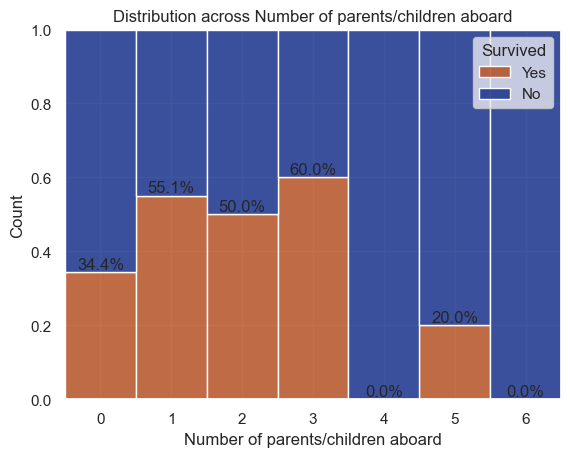

In [24]:
x, hue = "Number of parents/children aboard", "Survived"
df = train_df.loc[:, ["Survived"]]
df[x] = train_df.Parch.apply(str)
df.sort_values(x, inplace=True)

plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title(f"Distribution across {x}")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '55.4%'), Text(0, 0, '39.0%'), Text(0, 0, '33.7%')]

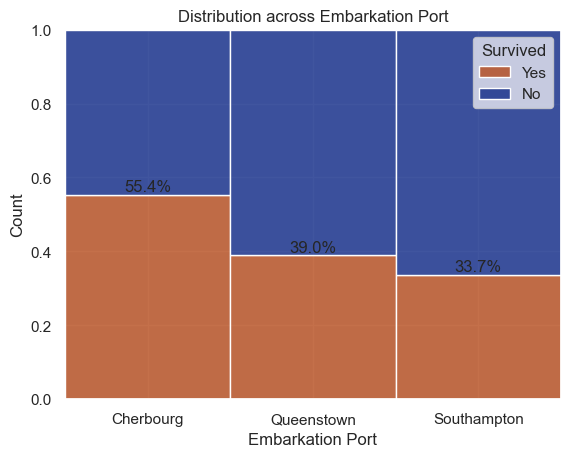

In [25]:
df = train_df.loc[:, ["Survived"]]
mappings = {
    "S": "Southampton", "C": "Cherbourg", "Q": "Queenstown"
}
df["Embarkation Port"] = train_df.Embarked.map(mappings)
df.sort_values("Embarkation Port", inplace=True)

x, hue = "Embarkation Port", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title("Distribution across Embarkation Port")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

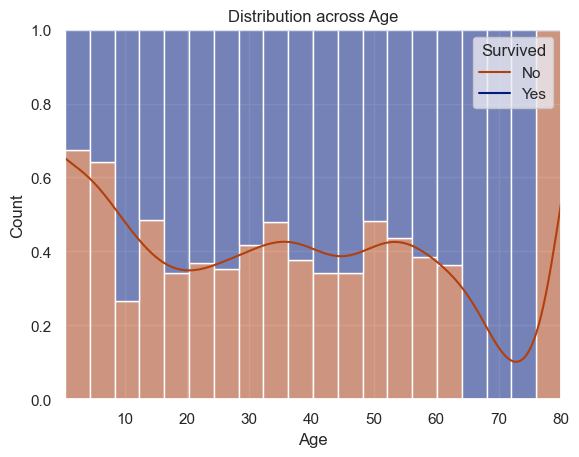

In [26]:
plot = sns.histplot(
    data=train_df, x="Age", hue="Survived",
    multiple="fill", kde=True
)
plot.set_title("Distribution across Age")
plot.legend(labels=["No", "Yes"], title="Survived")

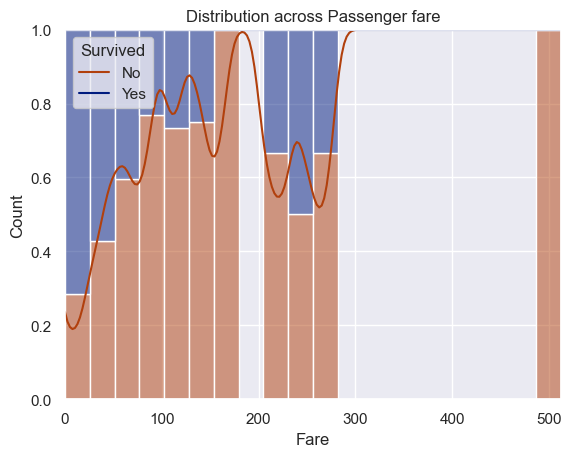

In [27]:
plot = sns.histplot(
    data=train_df, x="Fare", hue="Survived", bins=20,
    multiple="fill", kde=True
)
plot.set_title("Distribution across Passenger fare")
plot.legend(labels=["No", "Yes"], title="Survived")

## Data Pre-processing

### Feature Selection

In [28]:
columns = ["PassengerId", "Name", "Ticket", "Cabin"]
combined_df_cleaned = combined_df.drop(columns=columns)

combined_df_cleaned.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

### Feature Extraction

In [29]:
honorifics = combined_df.Name.str.extract(r"\s(\w+)\.")
combined_df_cleaned["Honorific"] = honorifics

combined_df_cleaned.Honorific

Train  0          Mr
       1         Mrs
       2        Miss
       3         Mrs
       4          Mr
               ...  
Test   413        Mr
       414      Dona
       415        Mr
       416        Mr
       417    Master
Name: Honorific, Length: 1309, dtype: object

In [30]:
df = combined_df_cleaned.pivot_table(
    index="Honorific", columns="Sex",
    aggfunc="size", fill_value=0
)
df["total"] = df.female + df.male
df.sort_values("total", ascending=False)

Sex,female,male,total
Honorific,,,
Mr,0,757,757
Miss,260,0,260
Mrs,197,0,197
Master,0,61,61
Rev,0,8,8
Dr,1,7,8
Col,0,4,4
Mlle,2,0,2
Ms,2,0,2


In [31]:
def generalise(row):
    return (
        row.Honorific
        if row.Honorific in general_honorifics
        else f"Other{row.Sex.title()}"
    )

general_honorifics = ["Mr", "Miss", "Mrs", "Master"]
df = combined_df_cleaned[["Honorific", "Sex"]]

honorifics = df.apply(generalise, axis=1)
combined_df_cleaned.Honorific = honorifics

combined_df_cleaned.Honorific

Train  0               Mr
       1              Mrs
       2             Miss
       3              Mrs
       4               Mr
                 ...     
Test   413             Mr
       414    OtherFemale
       415             Mr
       416             Mr
       417         Master
Name: Honorific, Length: 1309, dtype: object

[Text(0, 0, '15.7%'),
 Text(0, 0, '79.2%'),
 Text(0, 0, '69.8%'),
 Text(0, 0, '57.5%'),
 Text(0, 0, '25.0%'),
 Text(0, 0, '100.0%')]

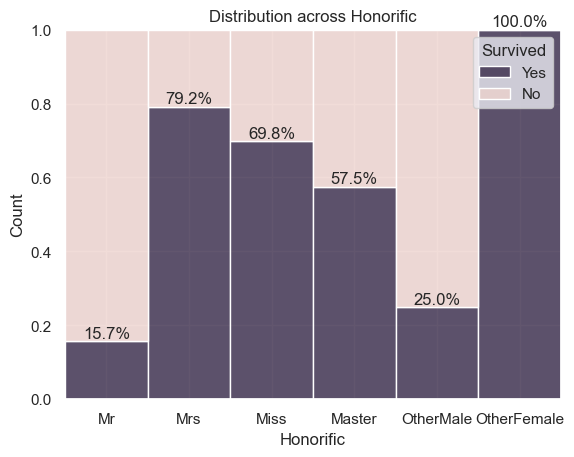

In [32]:
df, x, hue = combined_df_cleaned, "Honorific", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")

plot.set_title(f"Distribution across {x}")
plot.legend(labels=["Yes", "No"], title="Survived")

container = plot.containers[0]
labels = [f"{v.get_height():.1%}" for v in container]
plot.bar_label(container=container, labels=labels)

### Replacing Missing Values

In [33]:
df = combined_df_cleaned.groupby(["Honorific", "Pclass"])
age_means = df.Age.mean()

age_means

Honorific    Pclass
Master       1          6.984000
             2          2.757273
             3          6.090000
Miss         1         30.338983
             2         20.717083
             3         17.360874
Mr           1         41.450758
             2         32.346715
             3         28.318910
Mrs          1         43.208955
             2         33.518519
             3         32.326531
OtherFemale  1         34.428571
             2         28.000000
             3               NaN
OtherMale    1         49.214286
             2         40.700000
Name: Age, dtype: float64

In [34]:
female = combined_df_cleaned.Sex == "female"
class_3 = combined_df_cleaned.Pclass == 3
df = combined_df_cleaned.loc[female & class_3]
age_means[("OtherFemale", 3)] = df.Age.mean()
age_means = round(age_means * 2) / 2

combined_df_cleaned.drop(columns="Sex", inplace=True)

age_means

Honorific    Pclass
Master       1          7.0
             2          3.0
             3          6.0
Miss         1         30.5
             2         20.5
             3         17.5
Mr           1         41.5
             2         32.5
             3         28.5
Mrs          1         43.0
             2         33.5
             3         32.5
OtherFemale  1         34.5
             2         28.0
             3         22.0
OtherMale    1         49.0
             2         40.5
Name: Age, dtype: float64

In [35]:
def mean_age(row):
    return age_means[(row.Honorific, row.Pclass)]

age_series = combined_df_cleaned.apply(mean_age, axis=1)
combined_df_cleaned.Age.fillna(age_series, inplace=True)

combined_df_cleaned.Age

Train  0      22.0
       1      38.0
       2      26.0
       3      35.0
       4      35.0
              ... 
Test   413    28.5
       414    39.0
       415    38.5
       416    28.5
       417     6.0
Name: Age, Length: 1309, dtype: float64

In [36]:
df = combined_df_cleaned.copy()
df.Embarked = df.Embarked.astype(str)
df = df.groupby(["Embarked", "Pclass"])
fare_means = round(df.Fare.mean(), 2)

fare_means

Embarked  Pclass
C         1         106.85
          2          23.30
          3          11.02
Q         1          90.00
          2          11.74
          3          10.39
S         1          72.15
          2          21.21
          3          14.44
nan       1          80.00
Name: Fare, dtype: float64

In [37]:
def mean_fare(row):
    return fare_means[(str(row.Embarked), row.Pclass)]

fare_series = combined_df_cleaned.apply(mean_fare, axis=1)
combined_df_cleaned.Fare.fillna(fare_series, inplace=True)

combined_df_cleaned.Fare

Train  0        7.2500
       1       71.2833
       2        7.9250
       3       53.1000
       4        8.0500
                ...   
Test   413      8.0500
       414    108.9000
       415      7.2500
       416      8.0500
       417     22.3583
Name: Fare, Length: 1309, dtype: float64

### One Hot Encoding

In [38]:
dtype = "int64"
one_hot_encoder = OneHotEncoder(sparse=False, dtype=dtype)

x = combined_df_cleaned[["Honorific"]]
arrays = one_hot_encoder.fit_transform(x)
columns = one_hot_encoder.get_feature_names_out()

for column, row in zip(columns, arrays.T):
    if column != "Honorific_Mr":
        combined_df_cleaned[column] = row

combined_df_cleaned.drop(columns="Honorific", inplace=True)

column_bools = combined_df_cleaned.columns.isin(columns)
combined_df_cleaned.loc[:, column_bools]

Honorific_Master  Honorific_Miss  Honorific_Mrs  \
Train 0                   0               0              0   
      1                   0               0              1   
      2                   0               1              0   
      3                   0               0              1   
      4                   0               0              0   
...                     ...             ...            ...   
Test  413                 0               0              0   
      414                 0               0              0   
      415                 0               0              0   
      416                 0               0              0   
      417                 1               0              0   

           Honorific_OtherFemale  Honorific_OtherMale  
Train 0                        0                    0  
      1                        0                    0  
      2                        0                    0  
      3                        0                    0  
      4                        0                    0  
...                          ...                  ...  
Test  413                      0                    0  
      414                      1                    0  
      415                      0                    0  
      416                      0                    0  
      417                      0                    0  

[1309 rows x 5 columns]

In [39]:
dtype = "int64"
one_hot_encoder = OneHotEncoder(sparse=False, dtype=dtype)

x = combined_df_cleaned[["Embarked"]]
arrays = one_hot_encoder.fit_transform(x)
columns = one_hot_encoder.get_feature_names_out()

for column, row in zip(columns, arrays.T):
    if column != "Embarked_S":
        combined_df_cleaned[column] = row

combined_df_cleaned.drop(columns="Embarked", inplace=True)

column_bools = combined_df_cleaned.columns.isin(columns)
combined_df_cleaned.loc[:, column_bools]

Embarked_C  Embarked_Q  Embarked_nan
Train 0             0           0             0
      1             1           0             0
      2             0           0             0
      3             0           0             0
      4             0           0             0
...               ...         ...           ...
Test  413           0           0             0
      414           1           0             0
      415           0           0             0
      416           0           0             0
      417           1           0             0

[1309 rows x 3 columns]

### Assigning x and y

In [40]:
is_test = combined_df_cleaned.Survived.isnull()
x = combined_df_cleaned.drop(columns="Survived")

x_train = x[~is_test]
y_train = combined_df_cleaned.Survived[~is_test]
y_train.reset_index(drop=True, inplace=True)
x_test = x[is_test]

print("Shape of training x:", x_train.shape)
print("Shape of training y:", y_train.shape)
print("Shape of testing x:", x_test.shape)

Shape of training x: (891, 13)
Shape of training y: (891,)
Shape of testing x: (418, 13)


### Standard Scaling

In [41]:
column_names = x_train.columns
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)

x_train

array([[ 0.82737724, -0.55245609,  0.43279337, ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [-1.56610693,  0.63202468,  0.43279337, ...,  2.0745051 ,
        -0.30756234, -0.0474312 ],
       [ 0.82737724, -0.2563359 , -0.4745452 , ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       ...,
       [ 0.82737724, -0.88559131,  0.43279337, ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [-1.56610693, -0.2563359 , -0.4745452 , ...,  2.0745051 ,
        -0.30756234, -0.0474312 ],
       [ 0.82737724,  0.18784439, -0.4745452 , ..., -0.48204268,
         3.25137334, -0.0474312 ]])

In [42]:
x_test = scalar.transform(x_test)

x_test

array([[ 0.82737724,  0.37291951, -0.4745452 , ..., -0.48204268,
         3.25137334, -0.0474312 ],
       [ 0.82737724,  1.29829512,  0.43279337, ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [-0.36936484,  2.40874585, -0.4745452 , ..., -0.48204268,
         3.25137334, -0.0474312 ],
       ...,
       [ 0.82737724,  0.66903971, -0.4745452 , ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [ 0.82737724, -0.07126078, -0.4745452 , ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [ 0.82737724, -1.73693687,  0.43279337, ...,  2.0745051 ,
        -0.30756234, -0.0474312 ]])

## EDA / Data Visualisation

### Variance Inflation Factor (VIF)

In [43]:
def calculate_vif(arrays):
    vif = Parallel(n_jobs=-1, verbose=5)(
        delayed(variance_inflation_factor)(arrays, index) for index in range(arrays.shape[1])
    )
    vif_series = pd.Series(vif)

    return vif_series.sort_values(ascending=False)


calculate_vif(x_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:    8.2s remaining:   45.5s
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    8.2s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    8.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    8.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    8.7s finished


0     1.973467
1     1.822661
4     1.681236
5     1.497729
3     1.413528
6     1.401762
2     1.377887
7     1.225153
10    1.130043
11    1.123700
9     1.077347
8     1.034760
12    1.018122
dtype: float64

In [44]:
# def calculate_vif(df):
#     vif = Parallel(n_jobs=-1,verbose=5)(
#         delayed(variance_inflation_factor)(df.values, index) for index in range(df.shape[1])
#     )
#     vif_series = pd.Series(vif, index=df.columns)
#
#     return vif_series.sort_values(ascending=False)
#
#
# calculate_vif(train_df_cleaned.drop(columns=["Survived"]))

### Correlation

Text(0.5, 1.0, 'Correlation of variables with target variable')

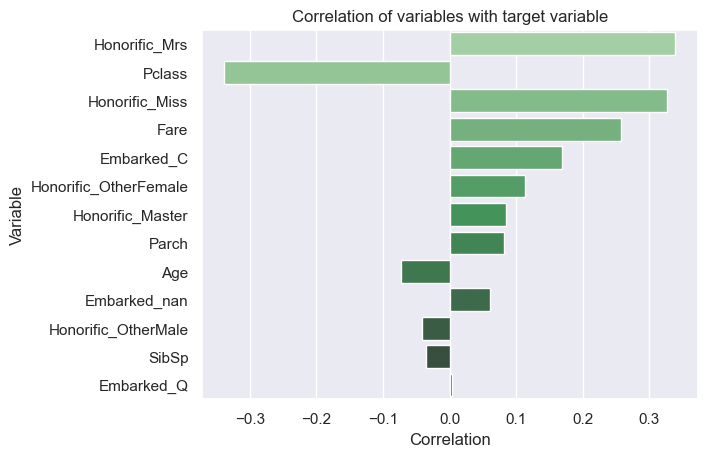

In [45]:
correlations = pd.DataFrame(x_train).corrwith(y_train)
data = {
    "Variable": column_names,
    "Correlation": correlations,
    "Abs": correlations.abs()
}
df = pd.DataFrame(data)
df.sort_values(
    "Abs", ascending=False, inplace=True, ignore_index=True
)

x, y = "Correlation", "Variable"
palette = sns.color_palette("Greens_d", len(df))
plot = sns.barplot(df, x=x, y=y, palette=palette)
plot.set_title(f"Correlation of variables with target variable")

## Model Implementation

In [46]:
index = [
    "Logistic Regression",
    "K-Nearest Neighbors",
    "Decision Tree",
    "Gradient Boosting",
    "Random Forest",
    "Support Vector Machine",
    "Gaussian Naive Bayes",
    "Perceptron",
    "Stochastic Gradient Descent",
    "Artificial Neural Network"
]
columns = ["Model", "Accuracy"]
model_df = pd.DataFrame(index=index, columns=columns)

### Logistic Regression

In [47]:
lr_model = LogisticRegression(random_state=5)
lr_model.fit(x_train, y_train)

LogisticRegression(random_state=5)

In [48]:
lr_train_accuracy = lr_model.score(x_train, y_train)

print(f"LR training accuracy: {lr_train_accuracy:.2%}")

LR training accuracy: 83.73%


In [49]:
y_train_pred = lr_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[487,  62],
       [ 83, 259]], dtype=int64)

In [50]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       549
         1.0       0.81      0.76      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



In [51]:
data = {
    "Variable": column_names,
    "Coefficient": lr_model.coef_[0]
}
df = pd.DataFrame(data)

df.sort_values("Coefficient", ascending=False)

,Variable,Coefficient
7,Honorific_Mrs,1.280688
6,Honorific_Miss,1.124341
5,Honorific_Master,0.672580
8,Honorific_OtherFemale,0.489944
4,Fare,0.165334
10,Embarked_C,0.158527
12,Embarked_nan,0.144481
11,Embarked_Q,0.072052
9,Honorific_OtherMale,0.001088
3,Parch,-0.277007


In [52]:
series = model_df.loc["Logistic Regression"]
series.Model = lr_model
series.Accuracy = lr_train_accuracy

### K-Nearest Neighbors

In [53]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [54]:
knn_train_accuracy = knn_model.score(x_train, y_train)

print(f"KNN training accuracy: {knn_train_accuracy:.2%}")

KNN training accuracy: 87.21%


In [55]:
y_train_pred = knn_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[503,  46],
       [ 68, 274]], dtype=int64)

In [56]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       549
         1.0       0.86      0.80      0.83       342

    accuracy                           0.87       891
   macro avg       0.87      0.86      0.86       891
weighted avg       0.87      0.87      0.87       891



In [57]:
series = model_df.loc["K-Nearest Neighbors"]
series.Model = knn_model
series.Accuracy = knn_train_accuracy

### Decision Tree

In [58]:
dtc_model = DecisionTreeClassifier(random_state=5)
dtc_model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=5)

In [59]:
dtc_train_accuracy = dtc_model.score(x_train, y_train)

print(f"DTC training accuracy: {dtc_train_accuracy:.2%}")

DTC training accuracy: 98.43%


In [60]:
y_train_pred = dtc_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[547,   2],
       [ 12, 330]], dtype=int64)

In [61]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       549
         1.0       0.99      0.96      0.98       342

    accuracy                           0.98       891
   macro avg       0.99      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



In [62]:
series = model_df.loc["Decision Tree"]
series.Model = dtc_model
series.Accuracy = dtc_train_accuracy

### Gradient Boosting

In [63]:
gbc_model = GradientBoostingClassifier(random_state=5)
gbc_model.fit(x_train, y_train)

GradientBoostingClassifier(random_state=5)

In [64]:
gbc_train_accuracy = gbc_model.score(x_train, y_train)

print(f"GBC training accuracy: {gbc_train_accuracy:.2%}")

GBC training accuracy: 89.00%


In [65]:
y_train_pred = gbc_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[522,  27],
       [ 71, 271]], dtype=int64)

In [66]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       549
         1.0       0.91      0.79      0.85       342

    accuracy                           0.89       891
   macro avg       0.89      0.87      0.88       891
weighted avg       0.89      0.89      0.89       891



In [67]:
series = model_df.loc["Gradient Boosting"]
series.Model = gbc_model
series.Accuracy = gbc_train_accuracy

### Random Forest

In [68]:
rfc_model = RandomForestClassifier(random_state=5)
rfc_model.fit(x_train, y_train)

RandomForestClassifier(random_state=5)

In [69]:
rfc_train_accuracy = rfc_model.score(x_train, y_train)

print(f"RFC training accuracy: {rfc_train_accuracy:.2%}")

RFC training accuracy: 98.43%


In [70]:
y_train_pred = rfc_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[544,   5],
       [  9, 333]], dtype=int64)

In [71]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       549
         1.0       0.99      0.97      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



In [72]:
series = model_df.loc["Random Forest"]
series.Model = rfc_model
series.Accuracy = rfc_train_accuracy

### Support Vector Machine

In [73]:
svc_model = SVC(random_state=5)
svc_model.fit(x_train, y_train)

SVC(random_state=5)

In [74]:
svc_train_accuracy = svc_model.score(x_train, y_train)

print(f"SVC training accuracy: {svc_train_accuracy:.2%}")

SVC training accuracy: 84.51%


In [75]:
y_train_pred = svc_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[499,  50],
       [ 88, 254]], dtype=int64)

In [76]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       549
         1.0       0.84      0.74      0.79       342

    accuracy                           0.85       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.85      0.84       891



In [77]:
series = model_df.loc["Support Vector Machine"]
series.Model = svc_model
series.Accuracy = svc_train_accuracy

### Gaussian Naive Bayes

In [78]:
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)

GaussianNB()

In [79]:
gnb_train_accuracy = gnb_model.score(x_train, y_train)

print(f"GNB training accuracy: {gnb_train_accuracy:.2%}")

GNB training accuracy: 63.75%


In [80]:
y_train_pred = gnb_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[547,   2],
       [321,  21]], dtype=int64)

In [81]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77       549
         1.0       0.91      0.06      0.12       342

    accuracy                           0.64       891
   macro avg       0.77      0.53      0.44       891
weighted avg       0.74      0.64      0.52       891



In [82]:
series = model_df.loc["Gaussian Naive Bayes"]
series.Model = gnb_model
series.Accuracy = gnb_train_accuracy

### Perceptron

In [83]:
p_model = Perceptron(random_state=5)
p_model.fit(x_train, y_train)

Perceptron(random_state=5)

In [84]:
p_train_accuracy = p_model.score(x_train, y_train)

print(f"Perceptron training accuracy: {p_train_accuracy:.2%}")

Perceptron training accuracy: 79.35%


In [85]:
y_train_pred = p_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[450,  99],
       [ 85, 257]], dtype=int64)

In [86]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       549
         1.0       0.72      0.75      0.74       342

    accuracy                           0.79       891
   macro avg       0.78      0.79      0.78       891
weighted avg       0.80      0.79      0.79       891



In [87]:
series = model_df.loc["Perceptron"]
series.Model = p_model
series.Accuracy = p_train_accuracy

### Stochastic Gradient Descent

In [88]:
sgd_model = SGDClassifier(random_state=5)
sgd_model.fit(x_train, y_train)

SGDClassifier(random_state=5)

In [89]:
sgd_train_accuracy = sgd_model.score(x_train, y_train)

print(f"SGD training accuracy: {sgd_train_accuracy:.2%}")

SGD training accuracy: 78.79%


In [90]:
y_train_pred = sgd_model.predict(x_train)

confusion_matrix(y_train, y_train_pred)

array([[472,  77],
       [112, 230]], dtype=int64)

In [91]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       549
         1.0       0.75      0.67      0.71       342

    accuracy                           0.79       891
   macro avg       0.78      0.77      0.77       891
weighted avg       0.79      0.79      0.79       891



In [92]:
series = model_df.loc["Stochastic Gradient Descent"]
series.Model = sgd_model
series.Accuracy = sgd_train_accuracy

### Artificial Neural Network

In [93]:
ann_model = Sequential()

ann_model.add(Dense(units=16, activation="relu", kernel_initializer="uniform", input_dim=13))
ann_model.add(Dropout(rate=0.2))

ann_model.add(Dense(units=16, activation="relu", kernel_initializer="uniform"))
ann_model.add(Dropout(rate=0.2))

ann_model.add(Dense(units=1, activation="relu", kernel_initializer="uniform"))

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [94]:
ann_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [95]:
history = ann_model.fit(x_train, y_train, epochs=30)

Epoch 1/30
28/28 [==============================] - 3s 5ms/step - loss: 1.9414 - accuracy: 0.6162
Epoch 2/30
28/28 [==============================] - 0s 3ms/step - loss: 1.3925 - accuracy: 0.6162
Epoch 3/30
28/28 [==============================] - 0s 3ms/step - loss: 1.1142 - accuracy: 0.6162
Epoch 4/30
28/28 [==============================] - 0s 4ms/step - loss: 0.8969 - accuracy: 0.6173
Epoch 5/30
28/28 [==============================] - 0s 3ms/step - loss: 0.7329 - accuracy: 0.6229
Epoch 6/30
28/28 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6633
Epoch 7/30
28/28 [==============================] - 0s 4ms/step - loss: 0.5454 - accuracy: 0.7059
Epoch 8/30
28/28 [==============================] - 0s 3ms/step - loss: 0.5039 - accuracy: 0.7497
Epoch 9/30
28/28 [==============================] - 0s 3ms/step - loss: 0.4833 - accuracy: 0.7733
Epoch 10/30
28/28 [==============================] - 0s 4ms/step - loss: 0.4685 - accuracy: 0.7767
Epoch 11/30
28/28 [

In [96]:
ann_train_metrics = ann_model.evaluate(x_train, y_train)
ann_train_accuracy = ann_train_metrics[1]

print(f"ANN training accuracy: {ann_train_accuracy:.2%}")

28/28 [==============================] - 1s 2ms/step - loss: 0.4265 - accuracy: 0.8373
ANN training accuracy: 83.73%


In [97]:
y_train_pred = ann_model.predict(x_train)
y_train_pred = (y_train_pred >= 0.5).astype(int)

confusion_matrix(y_train, y_train_pred, normalize="pred")

28/28 [==============================] - 0s 2ms/step


array([[0.84948097, 0.18530351],
       [0.15051903, 0.81469649]])

In [98]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       549
         1.0       0.81      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.84      0.84      0.84       891



In [99]:
series = model_df.loc["Artificial Neural Network"]
series.Model = ann_model
series.Accuracy = ann_train_accuracy

## Model Comparison

[Text(0, 0, '98.4%'),
 Text(0, 0, '98.4%'),
 Text(0, 0, '89.0%'),
 Text(0, 0, '87.2%'),
 Text(0, 0, '84.5%'),
 Text(0, 0, '83.7%'),
 Text(0, 0, '83.7%'),
 Text(0, 0, '79.3%'),
 Text(0, 0, '78.8%'),
 Text(0, 0, '63.7%')]

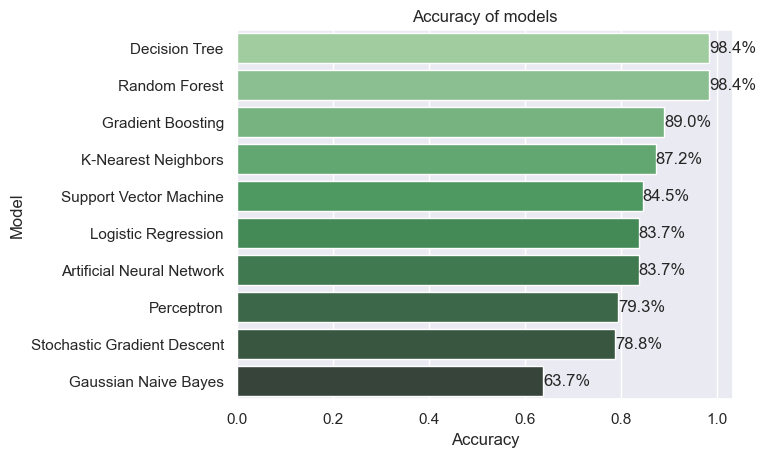

In [100]:
df = model_df.sort_values("Accuracy", ascending=False)
df["Model"] = df.index

x, y = "Accuracy", "Model"
palette = sns.color_palette("Greens_d", len(df))
plot = sns.barplot(df, x=x, y=y, palette=palette)
plot.set_title(f"Accuracy of models")

container = plot.containers[0]
labels = [f"{v.get_width():.1%}" for v in container]
plot.bar_label(container=container, labels=labels)

## Submission File

In [109]:
y_test_pred = dtc_model.predict(x_test)

data = {
    "PassengerId": test_df["PassengerId"],
    "Survived": y_test_pred
}
submission_df = pd.DataFrame(data, dtype="int64")

submission_df.to_csv("submission.csv", index=False)

submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
